In [1]:
import numpy as np
import pandas as pd

# from compiler.ast import flatten
from random import Random
from pandas import DataFrame
from numpy import log
from numpy import mat
from numpy import ones
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as pl
from sklearn.model_selection import KFold

In [2]:
class randomforest(object):
    n_estimators=0 # 树的数量
    max_features=0 #每棵树的选用数据集的最大特征数
    min_samples_split=0 #每棵树最小分割数
    min_gain=0 #每一颗树到min_gain之后就停止
    max_depth=0 #每一颗树的最大层数
    trees=[] #森林
    trees_feature=[] #用来记录每一个树用了哪些特征
    
    def __init__(self,n_estimators=100,min_samples_split=3, min_gain=0,
                 max_depth=None,max_features=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.max_depth = max_depth
        self.max_features = max_features 
        
#         #建立森林(bulid forest)
#         for _ in range(self.n_estimators):
#             tree =DecisionTreeClassifier(min_samples_split=self.min_samples_split, min_impurity_split = self.min_gain,
#                                       max_depth=self.max_depth)
#             self.trees.append(tree)
            #self.trees_feature.append(0)
        
    def get_bootstrap_data(self,X,Y):
        # 用bookstarp的方法获得n_estimators组随机的数据
        
        m=X.shape[0]
        Y=Y.reshape(m,1)
        
        #合并X和Y
        X_Y=np.hstack((X,Y))
        np.random.shuffle(X_Y) #X_Y随机化
        
        result_sets=[]
        for _ in range(self.n_estimators):
            now=np.random.choice(m,m,replace=True) #有放回,随机序列顺序
            bootstrap_X_Y = X_Y[now,:]
            bootstrap_X =  bootstrap_X_Y[:,:-1]
            bootstrap_Y =  bootstrap_X_Y[:,-1:]
            result_sets.append([bootstrap_X,bootstrap_Y])
            
        return result_sets
    
    def fit(self,X_train,Y_train):
        # 每一颗树都通过get_bookstrap_data获得随机的数据集
        
        sub_sets=self.get_bootstrap_data(X_train,Y_train)
        n_features=X_train.shape[1]
        
        if self.max_features == None:
            self.max_features = int(np.sqrt(n_features))

        for i in range (self.n_estimators):
            # 现在为每一颗树选择随机的特征
            tree =DecisionTreeClassifier(min_samples_split=self.min_samples_split,min_impurity_decrease = self.min_gain,
                                      max_depth=self.max_depth)
            
            sub_X,sub_Y=sub_sets[i]
            features=np.random.choice(n_features,self.max_features,replace=True)
            sub_X=sub_X[:,features]
            #print("X",sub_X)
            #print("X",sub_Y)
            tree.fit(sub_X,sub_Y)
            self.trees.append(tree)
            self.trees_feature.append(features)
    
    def predict(self,X):
        y_preds=[]
        for i in range(self.n_estimators):
            features=self.trees_feature[i]
            sub_X=X[:,features]
            y_pre=self.trees[i].predict(sub_X)
            y_preds.append(y_pre)
        
        y_preds=np.array(y_preds).T
        y_pred=[]
        
        for y_p in y_preds:
             y_pred.append(np.bincount(y_p.astype('int')).argmax()) #np.bincount()可以统计每个索引出现的次数,np.argmax()可以返回数组中最大值的索引
        
        return y_pred
        
        
            
            

In [3]:
adult_header=["age","workclass","fnlwgt","education","education-num",
              "marital-status","occupation","relationship","race","sex","capital-gain",
              "capital-loss","hours-per-week","native-country","label"]
adult_data=pd.read_csv("./adult.data",index_col=False,names=adult_header)
adult_test=pd.read_csv("./adult2.test",index_col=False,names=adult_header)

In [4]:
adult_data[adult_data==" ?"]=np.nan
adult_test[adult_test==" ?"]=np.nan
#print(adult_data["age"])
adult_data.dropna(axis=0,how='any',inplace=True)
adult_test.dropna(axis=0,how='any',inplace=True)

/home/larryytr/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [5]:
discre_name=["workclass","education","marital-status",
             "occupation","relationship","race",
             "sex","native-country","label"]
for name in discre_name:
    key=np.unique(adult_data[name])
    #print(key)
    le=preprocessing.LabelEncoder()
    le.fit(key)
    adult_test[name]=le.transform(adult_test[name])
    adult_data[name]=le.transform(adult_data[name])
#print(adult_data)

In [6]:
# X_data=adult_data.values[0:150,0:14]
# #print(X_data[:,0:14])
# Y_data=adult_data.values[0:150,14]
# #print(Y_data)
# X_test=adult_test.values[0:150,0:14]
# #print(X_test[:,0:14])
# Y_test=adult_test.values[0:150,14]
# print(Y_test)
# #记得删除
X_data=np.array(adult_data.values[0:150,0:14])
#print(X_data[:,0:14])
Y_data=np.array(adult_data.values[0:150,14])
#print(Y_data)
X_test=np.array(adult_test.values[0:150,0:14])
#print(X_test[:,0:14])
Y_test=np.array(adult_test.values[0:150,14])
X=np.vstack((X_data,X_test))
Y=np.hstack((Y_data,Y_test))
kf = KFold(n_splits=5,random_state=0)

for train_index, test_index in kf.split(X):
    print(train_index,test_index)
    X_data=X[train_index]
    X_test=X[test_index]
    Y_data=Y[train_index]
    Y_test=Y[test_index]
    break;

[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299] [ 0  1  2  3  4  5  6  7 

In [7]:
# a1 = np.random.choice(5,5,replace=False, p=None)
# print(a1)


In [8]:

# Y=np.random.rand(5,1)
# print(Y)
# X=np.random.rand(5,9)
# m=X.shape[0]
# print(X)
# X_Y = np.hstack((X,Y))
# np.random.shuffle(X_Y)

# data_sets = []
# for _ in range(1):
#     idm = np.random.choice(m,m,replace=True)
#     bootstrap_X_Y = X_Y[idm,:]
#     bootstrap_X =  bootstrap_X_Y[:,:-1]
#     bootstrap_Y =  bootstrap_X_Y[:,-1:]
#     data_sets.append([bootstrap_X,bootstrap_Y])

# print(data_sets)
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
0.8166666666666667
auc 0.5769230769230769
auc 0.5769230769230769


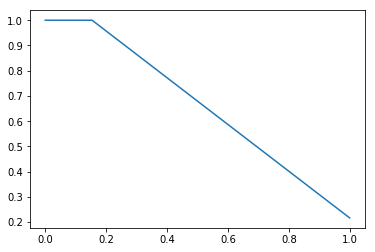

In [9]:
Random_classfier=randomforest() #参数记得填
# X_data.replace(np.nan, 0, inplace=True)
Random_classfier.fit(X_data,Y_data)
y_pred=Random_classfier.predict(X_test)
print(y_pred)
y_true=np.array(Y_test)
precision, recall, thresholds = precision_recall_curve( y_true,y_pred)
score=accuracy_score(y_true, y_pred)
print(score)
pr_auc = auc(recall, precision)
test_auc =metrics.roc_auc_score(y_true, y_pred)#验证集上的auc值
pl.plot(recall, precision)
print("auc",roc_auc_score(y_true, y_pred))
print("auc",test_auc)
